<a href="https://colab.research.google.com/github/ParitKansal/quora-question-pairs/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMPORT LIBRARIES

In [2]:
import warnings
warnings.filterwarnings('ignore')
!pip install distance
!pip install fuzzywuzzy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import spacy
from nltk.stem import PorterStemmer
import time
import distance
from nltk.corpus import stopwords
import nltk
from fuzzywuzzy import fuzz
nltk.download('stopwords')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16258 sha256=9f15ea79c661bc578bc260764c673eb412b1a2013daa20f1ccfbae7219cc1807
  Stored in directory: /root/.cache/pip/wheels/e8/bb/de/f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built distance


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/project_quora_question_pair/csv_files/train.csv')

#EDA

##Shape + Head

In [ ]:
df.shape

(404290, 6)

In [ ]:
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


##Null Value

In [ ]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [ ]:
df.dropna(inplace=True)

##Duplicate Vs Non-Duplicate

<Axes: >

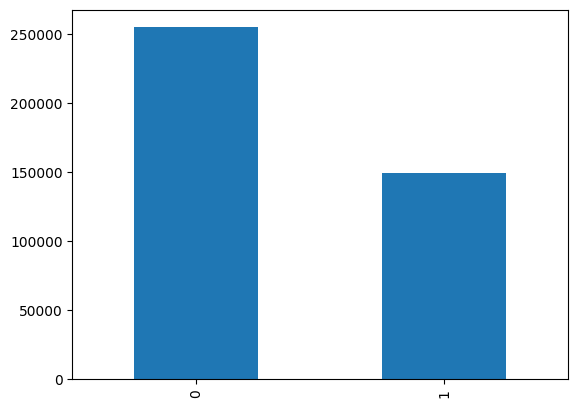

In [ ]:
df['is_duplicate'].value_counts().plot(kind='bar')

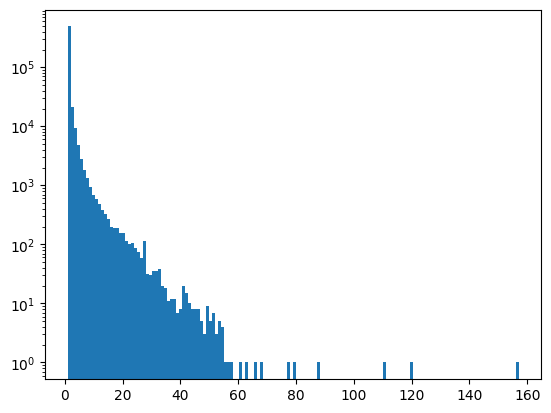

In [ ]:
qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
plt.hist(qid.value_counts().values,bins=150)
plt.yscale('log')
plt.show()

#PREPROCESSING

##Steps
1.   Lower Case
2.   Remove Emoji
3.   remove html
4.   remove url
5.   Replace certain special characters with their string equivalents
6.   Replace contractions
7.   Remove *puntuations*

In [ ]:
def preprocess(text):
  #lower case
  text = str(text).lower().strip()

  #remove emoji
  if(type(text) == str):
    emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F700-\U0001F77F"  # alchemical symbols
                                u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                                u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                                u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                                u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                                u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                                u"\U00002702-\U000027B0"  # Dingbats
                                u"\U000024C2-\U0001F251"
                                "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

  #remove html
  pattern = re.compile('<.*?>')
  text = pattern.sub(r'', text)

  #remove url
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  result = url_pattern.sub('', text)
  text = result

  # Replace certain special characters with their string equivalents
  text = text.replace('%', ' percent')
  text = text.replace('$', ' dollar ')
  text = text.replace('₹', ' rupee ')
  text = text.replace('€', ' euro ')
  text = text.replace('@', ' at ')
  text = text.replace('[math]', '')

  #contractions
  text = text.replace("'ve", " have")
  text = text.replace("n't", " not")
  text = text.replace("'re", " are")
  text = text.replace("'ll", " will")

  contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }
  text_decontracted = []
  for word in text.split():
    if word in contractions:
      word = contractions[word]
    text_decontracted.append(word)
  text = ' '.join(text_decontracted)

  #remove puntuations
  translator = str.maketrans('', '', string.punctuation)
  result = text.translate(translator)
  text = result

  return text

df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 2324math is divided by...,0
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0


In [ ]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

#FEATURE ENGINEERING

## len

In [ ]:
df['q1_len'] = df['question1'].str.len()
df['q2_len'] = df['question2'].str.len()

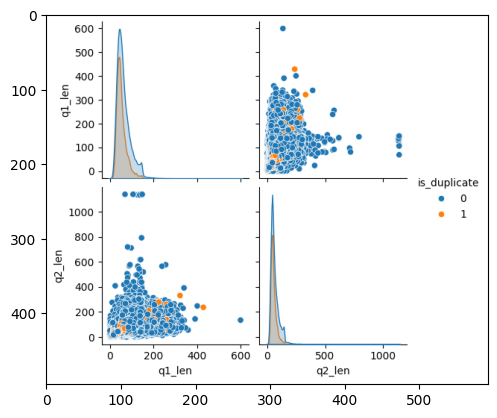

In [ ]:
img = plt.imread('/content/drive/MyDrive/project_quora_question_pair/photos_quora/photo1.png')
plt.imshow(img)

## fetch_length_features

In [ ]:
def fetch_length_features(row):
    q1 = row['question1']
    q2 = row['question2']

    length_features = [0.0]*7

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features

    #no of tokens in question1
    length_features[0] = len(q1_tokens)

    #no of tokens in question2
    length_features[1] = len(q2_tokens)

    # Absolute length features
    length_features[2] = abs(len(q1_tokens) - len(q2_tokens))

    #Average Token Length of both Questions
    length_features[3] = (len(q1_tokens) + len(q2_tokens))/2

    #longest common substring
    strs = list(distance.lcsubstrings(q1, q2))
    if strs:
        length_features[4] = len(strs[0])
        #ratio of longest common substring to min question len
        length_features[5] = len(strs[0]) / min(len(q1), len(q2))
        #ratio of longest common substring to max question len
        length_features[6] = len(strs[0]) / max(len(q1), len(q2))

    return length_features

length_features = df.apply(fetch_length_features, axis=1)

df['q1_token_no'] = list(map(lambda x: x[0], length_features))
df['q2_token_no'] = list(map(lambda x: x[1], length_features))
df['abs_len_diff'] = list(map(lambda x: x[2], length_features))
df['mean_len'] = list(map(lambda x: x[3], length_features))
df['longest_substr'] = list(map(lambda x: x[4], length_features))
df['longest_substr_ratio_min'] = list(map(lambda x: x[5], length_features))
df['longest_substr_ratio_max'] = list(map(lambda x: x[6], length_features))
#sns.pairplot(df[['q1_token_no', 'q2_token_no', 'abs_len_diff', 'mean_len', 'longest_substr', 'longest_substr_ratio_min', 'longest_substr_ratio_max', 'is_duplicate']], hue='is_duplicate')

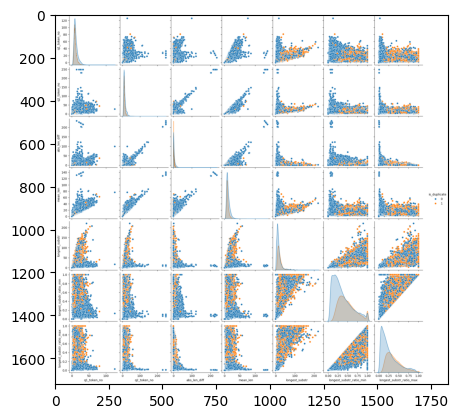

In [ ]:
img = plt.imread('/content/drive/MyDrive/project_quora_question_pair/photos_quora/photo2.png')
plt.imshow(img)

## fetch_token_features

In [ ]:
def fetch_token_features(row):
  q1 = row['question1']
  q2 = row['question2']

  STOP_WORDS = stopwords.words("english")

  token_features = [0.0]*11

  # Converting the Sentence into Tokens:
  q1_tokens = q1.split()
  q2_tokens = q2.split()

  if len(q1_tokens) == 0 or len(q2_tokens) == 0:
    return token_features

  # Get the non-stopwords in Questions
  q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
  q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

  #Get the stopwords in Questions
  q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
  q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

  # Get the common non-stopwords from Question pair
  common_word_count = len(q1_words.intersection(q2_words))

  # Get the common stopwords from Question pair
  common_stop_count = len(q1_stops.intersection(q2_stops))

  # Get the common Tokens from Question pair
  common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

  token_features[0]=common_token_count#common words
  token_features[1]=len(q1_tokens)+len(q2_tokens)#total words
  token_features[2]=token_features[0]/token_features[1];#ratio of common to total
  token_features[3] = common_word_count / (min(len(q1_words), len(q2_words)) + 0.0001)
  token_features[4] = common_word_count / (max(len(q1_words), len(q2_words)) + 0.0001)
  token_features[5] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + 0.0001)
  token_features[6] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + 0.0001)
  token_features[7] = common_token_count / (min(len(q1_tokens), len(q2_tokens)))
  token_features[8] = common_token_count / (max(len(q1_tokens), len(q2_tokens)))

  # Last word of both question is same or not
  token_features[9] = int(q1_tokens[-1] == q2_tokens[-1])

  # First word of both question is same or not
  token_features[10] = int(q1_tokens[0] == q2_tokens[0])


  return token_features

token_features = df.apply(fetch_token_features, axis=1)

df["common_words"] = list(map(lambda x: x[0], token_features))
df["total_words"] = list(map(lambda x: x[1], token_features))
df["ratio_of_common_to_total"] = list(map(lambda x: x[2], token_features))
df["cwc_min"] = list(map(lambda x: x[3], token_features))
df["cwc_max"] = list(map(lambda x: x[4], token_features))
df["csc_min"] = list(map(lambda x: x[5], token_features))
df["csc_max"] = list(map(lambda x: x[6], token_features))
df["ctc_min"] = list(map(lambda x: x[7], token_features))
df["ctc_max"] = list(map(lambda x: x[8], token_features))
df["last_word_eq"] = list(map(lambda x: x[9], token_features))
df["first_word_eq"] = list(map(lambda x: x[10], token_features))

#sns.pairplot(df[["common_words","total_words","ratio_of_common_to_total","cwc_min", "cwc_max", "csc_min", "csc_max", "ctc_min", "ctc_max", "last_word_eq", "first_word_eq", 'is_duplicate']], hue='is_duplicate')

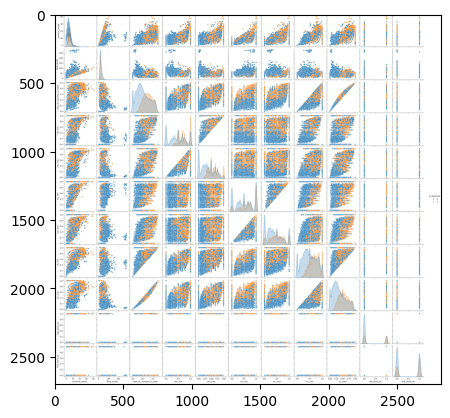

In [ ]:
img = plt.imread('/content/drive/MyDrive/project_quora_question_pair/photos_quora/photo3.png')
plt.imshow(img)

## fetch_fuzzy_features

In [ ]:
def fetch_fuzzy_features(row):

    q1 = row['question1']
    q2 = row['question2']

    fuzzy_features = [0.0]*4

    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

#sns.pairplot(df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

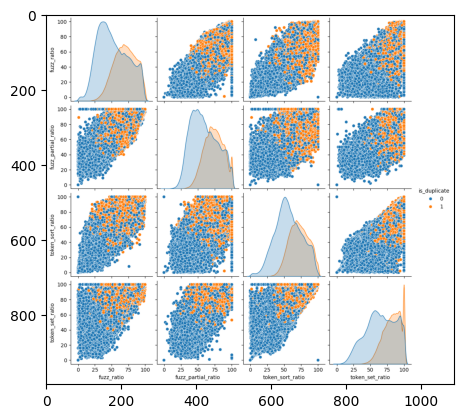

In [ ]:
img = plt.imread('/content/drive/MyDrive/project_quora_question_pair/photos_quora/photo4.png')
plt.imshow(img)

#WORD2VEC

In [ ]:
!pip install gensim

In [ ]:
from gensim.models import KeyedVectors

# Replace 'path/to/GoogleNews-vectors-negative300.bin.gz' with the path where you have downloaded the model
model_path = '/content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz'
word2vec_model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [ ]:
def apply_word2vec(text):
    # Split the text based on spaces
    tokens = text.split()
    # Apply Word2Vec embeddings
    embeddings = []
    for token in tokens:
        if token in word2vec_model.key_to_index:
            embeddings.append(word2vec_model[token])
    # Aggregate word embeddings
    if embeddings:
        aggregated_embedding = np.mean(embeddings, axis=0)  # Calculate mean along the axis 0
    else:
        # If no valid tokens found, use zeros as the aggregated embedding
        aggregated_embedding = np.zeros(word2vec_model.vector_size)

    return aggregated_embedding


# Apply Word2Vec to each question
df['question1_embeddings'] = df['question1'].apply(apply_word2vec)
df['question2_embeddings'] = df['question2'].apply(apply_word2vec)

a = word2vec_model.vector_size
del word2vec_model

# Split aggregated embeddings into separate columns
for i in range(a):
    df[f'question1_embedding_{i}'] = df['question1_embeddings'].apply(lambda x: x[i])

# Drop the original columns containing aggregated embeddings
df.drop(['question1_embeddings'], axis=1, inplace=True)

for i in range(a):
    df[f'question2_embedding_{i}'] = df['question2_embeddings'].apply(lambda x: x[i])

# Drop the original columns containing aggregated embeddings
df.drop(['question2_embeddings'], axis=1, inplace=True)

In [ ]:
df.to_csv('word2vec.csv', index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/project_quora_question_pair/csv_files/word2vec.csv')

#MODELLING

## Type of Model Selection

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/project_quora_question_pair/csv_files/word2vec.csv')

In [ ]:
df = df1.sample(30000, random_state = 1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate']), df['is_duplicate'], test_size=0.25, random_state=0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(X_train,y_train)

RandomForestClassifier()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
y_pred = classifier.predict(X_test)
print("Accuracy : ", accuracy_score(y_pred,y_test))
print("Confusion Matrix : ")
print(confusion_matrix(y_pred, y_test))

Accuracy :  0.7722666666666667
Confusion Matrix : 
[[3947  929]
 [ 779 1845]]


In [ ]:
import pickle

In [ ]:
pickle.dump(classifier,open('/content/RandomForest','wb'))

In [ ]:
from sklearn import svm
classifier = svm.SVC()
classifier.fit(X_train,y_train)

SVC()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
y_pred = classifier.predict(X_test)
print("Accuracy : ", accuracy_score(y_pred,y_test))
print("Confusion Matrix : ")
print(confusion_matrix(y_pred, y_test))

Accuracy :  0.7053333333333334
Confusion Matrix : 
[[3704 1188]
 [1022 1586]]


In [ ]:
import pickle

In [ ]:
pickle.dump(classifier,open('/content/SVM','wb'))

## Hyperparameter Tuning of Random Forest

### Tuning of model to determine best "n_estimators" parameter

In [ ]:
df = df1.sample(30000, random_state = 0)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate']), df['is_duplicate'], test_size=0.25, random_state=0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()

In [ ]:
from sklearn.model_selection import GridSearchCV
parameter={'n_estimators':[50, 75, 100, 115, 120]}
classifier_regressor = GridSearchCV(classifier, param_grid = parameter, scoring = 'accuracy', cv = 5, verbose = 2)
classifier_regressor.fit(X_train,y_train)

In [ ]:
classifier_regressor.best_params_

{'n_estimators': 115}

In [ ]:
y_pred = classifier_regressor.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
score=accuracy_score(y_pred,y_test)
print("Accuracy : ", score)

Accuracy :  0.7681333333333333


### Training of dataset based in the determined best "n_estimators"

In [ ]:
df = df1

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate']), df['is_duplicate'], test_size=0.25, random_state=0)
del df

In [ ]:
print(y_train.value_counts())
print(y_train.dtype)
print(y_test.value_counts())
print(y_test.dtype)

0    191214
1    111987
Name: is_duplicate, dtype: int64
int64
0    63792
1    37276
Name: is_duplicate, dtype: int64
int64


#### Training

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()

In [ ]:
from sklearn.model_selection import GridSearchCV
parameter={'n_estimators':[115]}

In [ ]:
classifier_regressor = GridSearchCV(classifier, param_grid = parameter, scoring = 'accuracy', cv = 5, verbose = 2)

In [ ]:
classifier_regressor.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ...................................n_estimators=115; total time=23.8min
[CV] END ...................................n_estimators=115; total time=23.8min
[CV] END ...................................n_estimators=115; total time=23.5min
[CV] END ...................................n_estimators=115; total time=24.0min
[CV] END ...................................n_estimators=115; total time=23.2min


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [115]}, scoring='accuracy', verbose=2)

In [ ]:
print(classifier_regressor.cv_results_['mean_test_score'])

[0.81846037]


#### Model Testing

In [ ]:
y_pred = classifier_regressor.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
score=accuracy_score(y_pred,y_test)
print("Accuracy : ", score)
print("Confusion Matrix : ")
print(confusion_matrix(y_pred, y_test))

Accuracy :  0.8233169747100961
Confusion Matrix : 
[[55804  9869]
 [ 7988 27407]]


#### Model Saving

In [ ]:
import pickle

In [ ]:
pickle.dump(classifier_regressor, open('/content/Model_using_best_n-estimaters', 'wb'))

### Tuning of model to determine the other best parameters

In [ ]:
df = df1.sample(15000, random_state = 1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate']), df['is_duplicate'], test_size=0.25, random_state=0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()

In [ ]:
from sklearn.model_selection import GridSearchCV
parameter={'criterion':['log_loss'],
           'max_depth':[None,3,5],
           'max_samples':[0.5,0.75,1.0],
           'max_features':['sqrt', 'log2', 0.5, 1.0],
          }

In [ ]:
classifier_regressor = GridSearchCV(classifier, param_grid = parameter, scoring = 'accuracy', cv = 5, verbose = 2)

In [ ]:
classifier_regressor.fit(X_train,y_train)

In [ ]:
classifier_regressor.best_params_

{'criterion': 'log_loss',
 'max_depth': None,
 'max_features': 0.5,
 'max_samples': 1.0}

In [ ]:
y_pred = classifier_regressor.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy : ", accuracy_score(y_pred,y_test))

Accuracy :  0.7736


In [ ]:
import pickle

In [ ]:
pickle.dump(classifier_regressor, open('/content/Model_using_other_best_parameters', 'wb'))

# FINAL MODELLING (based on all the estimated best parameters)

## Train Test Split

In [4]:
df1 = pd.read_csv('/content/drive/MyDrive/project_quora_question_pair/csv_files/word2vec.csv')

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate']), df['is_duplicate'], test_size=0.25, random_state=0)
del df

## Random Forest Classifier Training

In [17]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()

In [18]:
from sklearn.model_selection import GridSearchCV
parameter={'n_estimators': [115],
           'criterion': ['log_loss'],
           'max_depth': [None],
           'max_features': [0.5],
           'max_samples': [1.0]}

In [19]:
classifier_regressor = GridSearchCV(classifier, param_grid = parameter, scoring = 'accuracy', cv = 3, verbose = 2)
classifier_regressor.fit(X_train,y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END criterion=log_loss, max_depth=None, max_features=0.5, max_samples=1.0, n_estimators=115; total time=   0.6s
[CV] END criterion=log_loss, max_depth=None, max_features=0.5, max_samples=1.0, n_estimators=115; total time=   0.8s
[CV] END criterion=log_loss, max_depth=None, max_features=0.5, max_samples=1.0, n_estimators=115; total time=   0.8s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['log_loss'], 'max_depth': [None],
                         'max_features': [0.5], 'max_samples': [1.0],
                         'n_estimators': [115]},
             scoring='accuracy', verbose=2)

## Model Testing

In [20]:
print("Accuracy in cv0 = ", classifier_regressor.cv_results_['split0_test_score'])
print("Accuracy in cv0 = ", classifier_regressor.cv_results_['split1_test_score'])
print("Accuracy in cv0 = ", classifier_regressor.cv_results_['split2_test_score'])
print("Mean Accuracy =   ", classifier_regressor.cv_results_['mean_test_score'])
print("Std of Accuracy = ", classifier_regressor.cv_results_['std_test_score'])

Accuracy in cv0 =  [0.72]
Accuracy in cv0 =  [0.68]
Accuracy in cv0 =  [0.8]
Mean Accuracy =    [0.73333333]
Std of Accuracy =  [0.04988877]


In [22]:
y_pred = classifier_regressor.predict(X_test)

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix
score=accuracy_score(y_pred,y_test)
print("Accuracy : ", score)
print("Confusion Matrix : ")
print(confusion_matrix(y_pred, y_test))

Accuracy :  0.6
Confusion Matrix : 
[[11  4]
 [ 6  4]]


## Model Saving

In [ ]:
import pickle
pickle.dump(classifier_regressor, open('/content/Final_model', 'wb'))

In [ ]:
! cp final_model "/content/drive/MyDrive/project_quora_question_pair/models"